In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
from skimage.io import imread, imshow

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
110046,00029943_027.png,Effusion|Infiltration|Mass,27,29943,65,F,AP,3056,2544,0.139,0.139,NaN
59312,00014664_008.png,Consolidation|Effusion|Mass,8,14664,57,M,AP,2500,2048,0.168,0.168,NaN
96425,00025381_010.png,No Finding,10,25381,43,M,PA,2992,2991,0.143,0.143,NaN


In [3]:
print(all_xray_df.columns)

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')


In [4]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1:
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)
all_xray_df.head(10)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Demographic analysis on total data

(array([4.1465e+04, 7.0265e+04, 3.7400e+02, 1.0000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([  1. ,  42.3,  83.6, 124.9, 166.2, 207.5, 248.8, 290.1, 331.4,
        372.7, 414. ]),
 <a list of 10 Patch objects>)

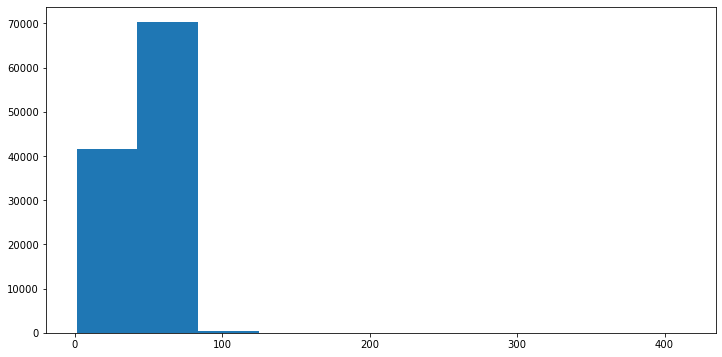

In [5]:
# Patient age
plt.figure(figsize=(12,6))
plt.hist(all_xray_df['Patient Age'])

In [6]:
pa_outliers = all_xray_df[all_xray_df['Patient Age'] < 100].index.tolist()
all_xray_df_mod = all_xray_df.loc[pa_outliers]
all_xray_df_mod.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
48955,00012411_001.png,No Finding,1,12411,73,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
52159,00013161_002.png,No Finding,2,13161,45,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
48914,00012392_004.png,Atelectasis|Infiltration,4,12392,49,M,AP,2048,2500,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


(array([ 1803.,  5021., 12798., 14580., 18664., 26481., 20790.,  9793.,
         1917.,   257.]),
 array([ 1. , 10.4, 19.8, 29.2, 38.6, 48. , 57.4, 66.8, 76.2, 85.6, 95. ]),
 <a list of 10 Patch objects>)

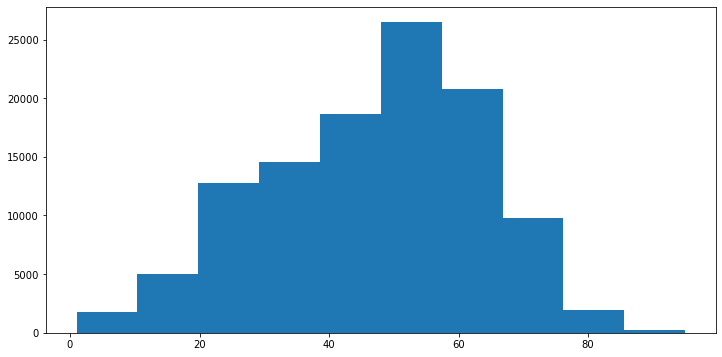

In [7]:
plt.figure(figsize=(12,6))
plt.hist(all_xray_df_mod['Patient Age'])

M    63340
F    48780
Name: Patient Gender, dtype: int64

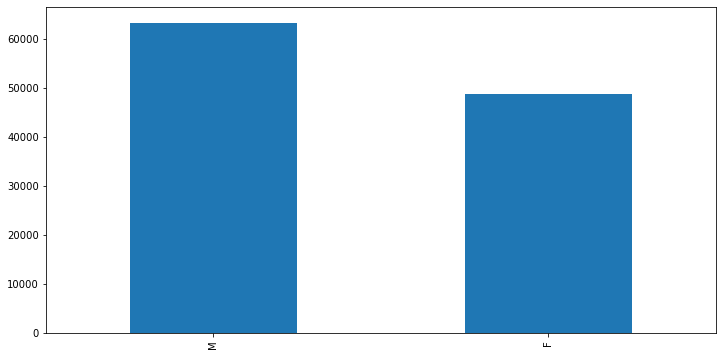

In [8]:
# Patient Gender
plt.figure(figsize=(12,6))
pg = all_xray_df['Patient Gender'].value_counts()
pg.plot(kind = 'bar')
pg

PA    67310
AP    44810
Name: View Position, dtype: int64

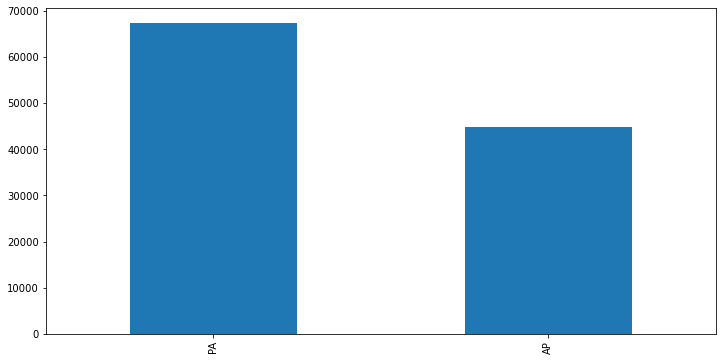

In [9]:
plt.figure(figsize=(12,6))
vp = all_xray_df['View Position'].value_counts()
vp.plot(kind='bar')
vp

In [10]:
all_xray_df[all_labels].sum()/len(all_xray_df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

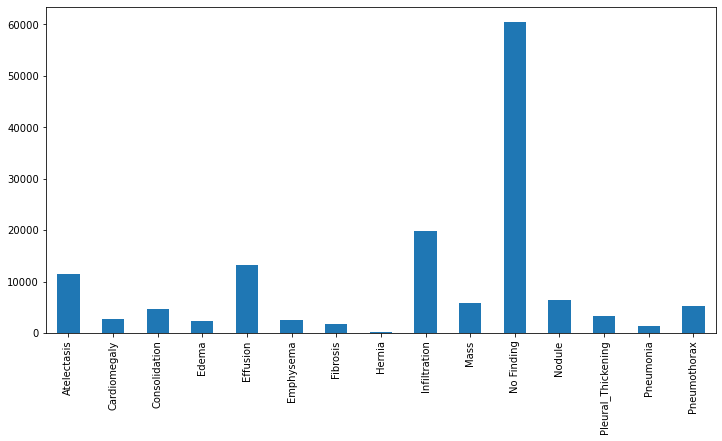

In [11]:
plt.figure(figsize=(12,6))
all_xray_df[all_labels].sum().plot(kind='bar')

0.0    110689
1.0      1431
Name: Pneumonia, dtype: int64

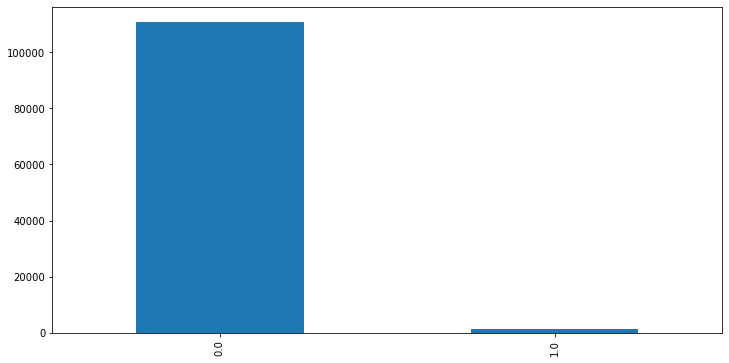

In [12]:
plt.figure(figsize=(12,6))
pneumonia_cases = all_xray_df['Pneumonia'].value_counts()
pneumonia_cases.plot(kind='bar')
pneumonia_cases

(array([615., 811.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  2.,  43.,  84., 125., 166., 207., 248., 289., 330., 371., 412.]),
 <a list of 10 Patch objects>)

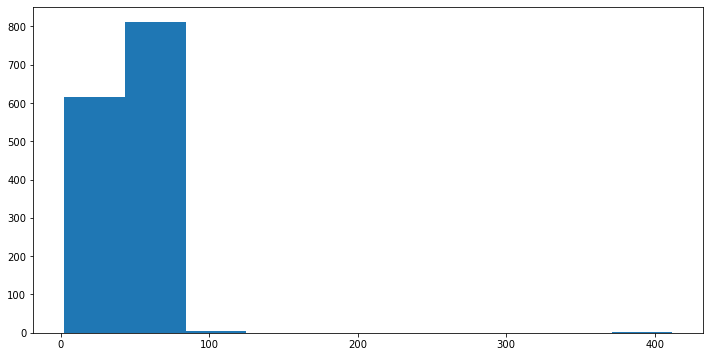

In [13]:
plt.figure(figsize=(12,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia == 1]['Patient Age'])

(array([ 41.,  85., 174., 203., 196., 243., 266., 175.,  39.,   8.]),
 array([ 2. , 10.8, 19.6, 28.4, 37.2, 46. , 54.8, 63.6, 72.4, 81.2, 90. ]),
 <a list of 10 Patch objects>)

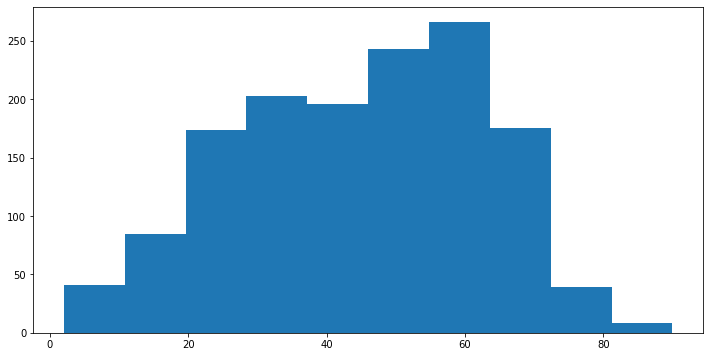

In [14]:
plt.figure(figsize=(12,6))
plt.hist(all_xray_df_mod[all_xray_df_mod.Pneumonia == 1]['Patient Age'])

Pneumonia                                          322
Infiltration|Pneumonia                             199
Edema|Infiltration|Pneumonia                       137
Atelectasis|Pneumonia                              108
Edema|Pneumonia                                     83
Effusion|Pneumonia                                  54
Effusion|Infiltration|Pneumonia                     42
Consolidation|Pneumonia                             36
Atelectasis|Infiltration|Pneumonia                  34
Atelectasis|Effusion|Pneumonia                      23
Edema|Effusion|Infiltration|Pneumonia               21
Nodule|Pneumonia                                    19
Edema|Effusion|Pneumonia                            19
Atelectasis|Effusion|Infiltration|Pneumonia         18
Atelectasis|Consolidation|Pneumonia                 15
Consolidation|Infiltration|Pneumonia                13
Pleural_Thickening|Pneumonia                        11
Infiltration|Nodule|Pneumonia                       11
Mass|Pneum

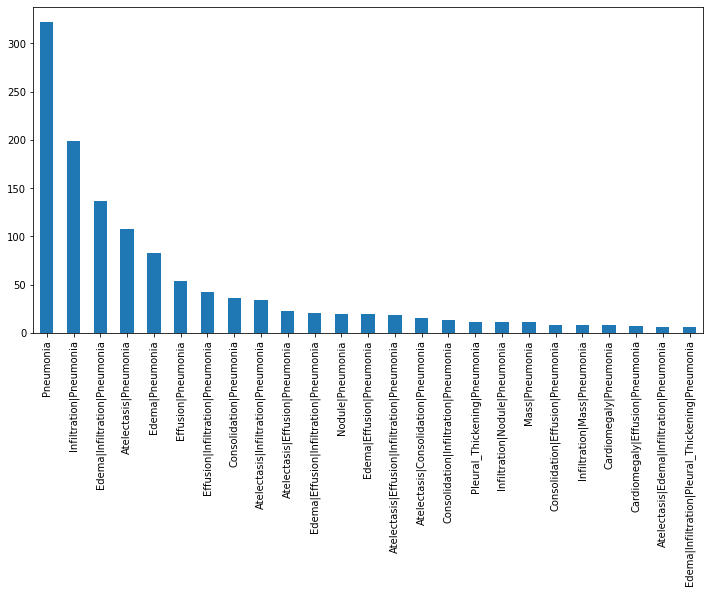

In [15]:
plt.figure(figsize=(12,6))
all_xray_df[all_xray_df.Pneumonia == 1]['Finding Labels'].value_counts()[0:25].plot(kind ='bar')
all_xray_df[all_xray_df.Pneumonia == 1]['Finding Labels'].value_counts()[0:25]

In [18]:
patient_cases = all_xray_df_wof['Patient ID'].value_counts()
patient_cases

10007    139
12834    121
13670    119
13993    116
15530    108
        ... 
12692      1
14709      1
4464       1
16730      1
2049       1
Name: Patient ID, Length: 14402, dtype: int64

In [17]:
all_xray_df_wof= all_xray_df[all_xray_df['Finding Labels'] != 'No Finding']
all_xray_df_wof.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,00000003_006.png,Hernia,6,3,79,F,PA,2992,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
patient_diseases = all_xray_df_wof.groupby('Patient ID')[all_labels].max().reset_index()
patient_diseases_count = all_xray_df_wof.groupby('Patient ID')[all_labels].max().sum(axis=1).reset_index()
patient_diseases_count.columns =['Patient ID', 'Disease Count']
#patient_diseases.loc[patient_diseases['Patient ID'] == 10007]
patient_diseases.head(10)

,Patient ID,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,11,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,12,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,13,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0


In [20]:
patient_diseases.loc[patient_diseases['Patient ID'] == 1]

,Patient ID,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
patient_diseases_count.loc[patient_diseases_count['Patient ID'] == 1]

,Patient ID,Disease Count
0,1,3.0


In [22]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
4845,00025465_001.png,No Finding,1,25465,058Y,M,PA,2992,2991,0.143,0.143
4755,00024752_000.png,No Finding,0,24752,053Y,F,PA,2992,2991,0.143,0.143
1850,00009736_016.png,Pneumothorax,16,9736,065Y,F,PA,2992,2991,0.143,0.143


In [23]:
all_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}):{}'.format(len(all_labels),all_labels))
for c_label in all_labels:
    if len(c_label)>1:
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
sample_df.head()

All Labels (15):['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
healthy_ind = sample_df[sample_df['No Finding'] == 1].index.tolist()
disease_ind = sample_df[sample_df['No Finding'] == 0].index.tolist()
healthy_df = sample_df.loc[healthy_ind]
disease_df = sample_df.loc[disease_ind]

In [29]:
healthy_df.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Path
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000017_001.png
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000042_002.png
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000057_001.png
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000061_019.png
12,00000080_005.png,No Finding,5,80,067Y,F,PA,1884,2021,0.194311,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000080_005.png
13,00000083_000.png,No Finding,0,83,056Y,F,PA,2048,2500,0.171000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000083_000.png
17,00000099_006.png,No Finding,6,99,058Y,F,AP,2048,2500,0.168000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000099_006.png
24,00000121_004.png,No Finding,4,121,054Y,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000121_004.png
28,00000165_008.png,No Finding,8,165,078Y,M,PA,2940,2900,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000165_008.png
34,00000188_001.png,No Finding,1,188,045Y,M,PA,2698,2991,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000188_001.png


In [30]:
disease_df.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,/data/images_001/images/00000013_005.png
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000013_026.png
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000030_001.png
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000032_001.png
5,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000040_003.png
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000061_002.png
10,00000061_025.png,Consolidation|Effusion|Infiltration|Nodule,25,61,077Y,M,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,/data/images_001/images/00000061_025.png
11,00000079_000.png,Mass,0,79,063Y,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000079_000.png
14,00000084_000.png,Effusion,0,84,057Y,F,PA,2048,2500,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000084_000.png
15,00000096_006.png,Effusion,6,96,067Y,F,PA,2242,2546,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000096_006.png


In [31]:
all_image_paths = {os.path.basename(x): x for x in
                   glob(os.path.join('/data','images*','*','*.png'))}
sample_df['Path'] = sample_df['Image Index'].map(all_image_paths.get)
sample_df.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,/data/images_001/images/00000013_005.png
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000013_026.png
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000017_001.png
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000030_001.png
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000032_001.png
5,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000040_003.png
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000042_002.png
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000057_001.png
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000061_002.png
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000061_019.png


In [32]:
healthy_1 = imread(healthy_df['Path'].iloc[8])

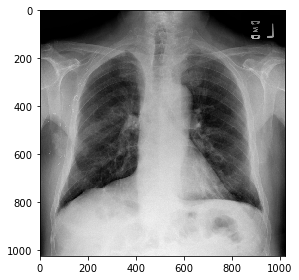

In [33]:
imshow(healthy_1)

In [34]:
Disease_1 = imread(disease_df[disease_df.Pneumonia == 1].sample(1)['Path'].values[0])

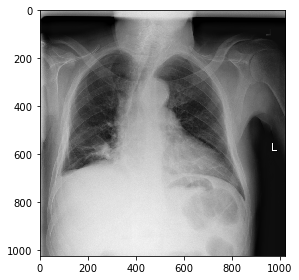

In [35]:
imshow(Disease_1)

In [36]:
only_pneumonia_df = disease_df[(disease_df.Pneumonia==1) & (disease_df['Finding Labels'].str.split('|').apply(lambda x: len(x) == 1))]

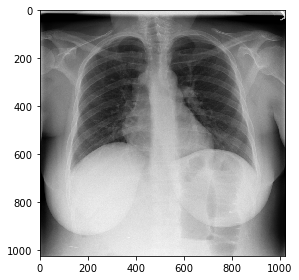

In [37]:
Pneumonia_1 = imread(only_pneumonia_df['Path'].iloc[5])
imshow(Pneumonia_1)

(array([3.9322e+04, 1.9503e+04, 8.5900e+02, 8.1500e+02, 8.0700e+02,
        8.3500e+02, 8.6500e+02, 8.0600e+02, 8.0000e+02, 7.6300e+02,
        7.6400e+02, 8.4800e+02, 8.6400e+02, 9.7600e+02, 9.9800e+02,
        1.0800e+03, 1.1690e+03, 1.2760e+03, 1.1950e+03, 1.3470e+03,
        1.4700e+03, 1.5940e+03, 1.7200e+03, 1.8390e+03, 1.8020e+03,
        2.0180e+03, 2.1050e+03, 2.2530e+03, 0.0000e+00, 2.2780e+03,
        2.4490e+03, 2.5870e+03, 2.6760e+03, 2.8460e+03, 2.8610e+03,
        2.9780e+03, 2.9530e+03, 3.0980e+03, 3.1920e+03, 3.3650e+03,
        3.4900e+03, 3.5590e+03, 3.8310e+03, 3.9020e+03, 3.9850e+03,
        4.0770e+03, 4.0390e+03, 4.2870e+03, 4.1990e+03, 4.2590e+03,
        4.3410e+03, 4.4430e+03, 4.3540e+03, 4.5450e+03, 4.5180e+03,
        4.7830e+03, 0.0000e+00, 4.6480e+03, 4.6600e+03, 4.8160e+03,
        4.8530e+03, 4.9790e+03, 5.1430e+03, 4.8840e+03, 4.8160e+03,
        4.9960e+03, 4.9220e+03, 4.9160e+03, 5.0180e+03, 5.1110e+03,
        4.9860e+03, 5.0160e+03, 5.0840e+03, 5.09

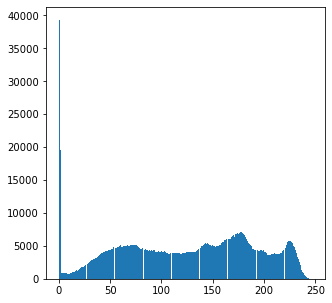

In [40]:
plt.figure(figsize=(5,5))
plt.hist(healthy_1.ravel(), bins=256)

(array([1.4184e+04, 1.0180e+03, 9.5300e+02, 9.4000e+02, 9.7800e+02,
        1.3790e+03, 1.4590e+03, 1.6590e+03, 2.0180e+03, 1.6730e+03,
        1.6230e+03, 1.5840e+03, 1.4880e+03, 1.5930e+03, 1.5860e+03,
        1.4510e+03, 1.3760e+03, 1.3400e+03, 1.2370e+03, 1.2100e+03,
        1.2210e+03, 1.1880e+03, 1.1050e+03, 1.1610e+03, 1.2080e+03,
        1.2660e+03, 1.3250e+03, 1.4550e+03, 1.7390e+03, 1.9360e+03,
        2.2010e+03, 2.4300e+03, 2.7280e+03, 2.9430e+03, 3.1400e+03,
        3.3270e+03, 3.3780e+03, 3.4260e+03, 3.6230e+03, 3.5570e+03,
        3.6470e+03, 3.6380e+03, 3.7480e+03, 3.8710e+03, 3.9480e+03,
        4.1820e+03, 4.2780e+03, 4.4660e+03, 4.5480e+03, 4.5890e+03,
        4.6650e+03, 4.7130e+03, 4.6770e+03, 4.8090e+03, 4.7330e+03,
        4.6980e+03, 4.8140e+03, 4.9270e+03, 4.8620e+03, 4.8810e+03,
        4.9160e+03, 4.6510e+03, 4.5310e+03, 4.4530e+03, 4.4590e+03,
        4.4500e+03, 4.3670e+03, 4.2890e+03, 4.1450e+03, 4.0860e+03,
        4.0460e+03, 4.0810e+03, 3.9490e+03, 3.98

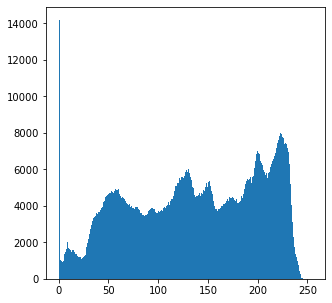

In [41]:
plt.figure(figsize=(5,5))
plt.hist(Pneumonia_1.ravel(), bins = 256)

In [44]:
only_infiltration_df = disease_df[(disease_df.Infiltration==1) & (disease_df['Finding Labels'].str.split('|').apply(lambda x: len(x) == 1))]

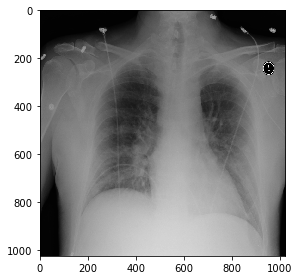

In [47]:
Infiltration_1 = imread(only_infiltration_df['Path'].iloc[3])
imshow(Infiltration_1)

(array([1.5170e+03, 1.6270e+03, 4.2827e+04, 3.4434e+04, 4.0480e+03,
        1.0340e+03, 1.0540e+03, 1.0460e+03, 1.1130e+03, 1.1230e+03,
        1.1340e+03, 1.2730e+03, 1.0760e+03, 1.0350e+03, 1.0860e+03,
        1.1870e+03, 1.1030e+03, 9.9200e+02, 1.0930e+03, 1.1390e+03,
        1.0550e+03, 9.7700e+02, 1.0110e+03, 9.4300e+02, 8.5600e+02,
        1.0230e+03, 1.0470e+03, 1.0340e+03, 9.8500e+02, 1.0770e+03,
        1.1350e+03, 1.2710e+03, 1.4730e+03, 1.4800e+03, 1.6490e+03,
        1.9050e+03, 1.9450e+03, 2.0350e+03, 2.0250e+03, 2.1400e+03,
        2.3060e+03, 2.4630e+03, 2.6060e+03, 2.6000e+03, 2.7520e+03,
        2.7920e+03, 2.8090e+03, 3.0150e+03, 3.1110e+03, 3.2530e+03,
        3.3840e+03, 3.3430e+03, 3.2630e+03, 3.3180e+03, 3.3500e+03,
        3.4010e+03, 3.4390e+03, 3.2180e+03, 3.1780e+03, 3.0650e+03,
        2.9000e+03, 2.8860e+03, 2.9270e+03, 3.0320e+03, 3.0200e+03,
        2.9150e+03, 2.8970e+03, 2.9330e+03, 2.9940e+03, 3.1060e+03,
        3.2150e+03, 3.4320e+03, 3.5860e+03, 3.54

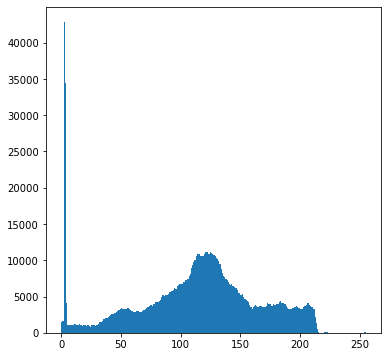

In [48]:
plt.figure(figsize=(6,6))
plt.hist(Infiltration_1.ravel(),bins =256)